#  kaggle 자전거 수요 예측

- 프로그래머스 강의: https://programmers.co.kr/learn/courses/21/lessons/942#

- Bike Sharing Demand | Kaggle: https://www.kaggle.com/c/bike-sharing-demand

- You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

**Evaluation**     
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE)


**Description**
- datetime - hourly date + timestamp      
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter       
- holiday - whether the day is considered a holiday       
- workingday - whether the day is neither a weekend nor holiday      
- weather 
   - 1: Clear, Few clouds, Partly cloudy, Partly cloudy       
   - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist      
   - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds      
   - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog      
- temp - temperature in Celsius      
- atemp - "feels like" temperature in Celsius      
- humidity - relative humidity        
- windspeed - wind speed          
- casual - number of non-registered user rentals initiated           
- registered - number of registered user rentals initiated          
- count - number of total rentals              

분류와 회귀중 회귀와 관련된 문제 + label 있는 지도학습 => 자전거 대여량을 예측하는 문제이기 때문에

# EDA & Visualization

In [1]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프 그리기 위해
%matplotlib inline

# 그래프에서 '격자'있는 (숫자 범위가 눈에 잘 띄도록) ggplot sytle 사용
plt.style.use('ggplot')

# 그래프 마이너스 폰트 깨지는 문제 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 그래프에서 한글 폰트 깨지는 문제 대처
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)
from IPython.display import set_matplotlib_formats 
set_matplotlib_formats("retina")

In [3]:
train = pd.read_csv('train.csv', parse_dates = ['datetime'])   # parse_dates옵션: 지정한 열을 datetime type으로 지정해서 불러와줌
train.shape

(10886, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [7]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [8]:
# !pip install missingno

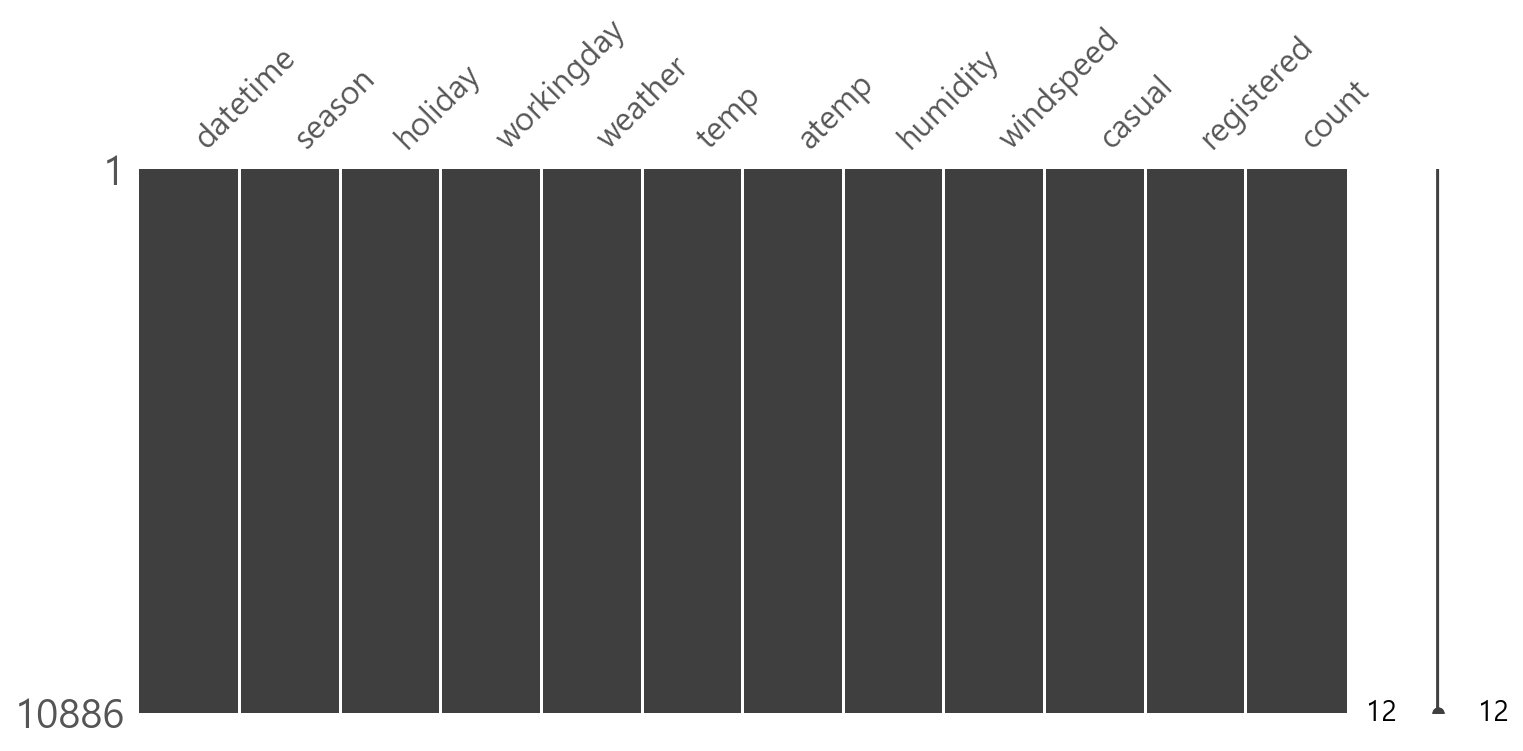

In [9]:
# null data 있는지 시각화
import missingno as msno
msno.matrix(train, figsize = (12,5))

In [10]:
# datetime 나눠서/쪼개서 보기
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second

In [11]:
train.shape

(10886, 18)

In [12]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

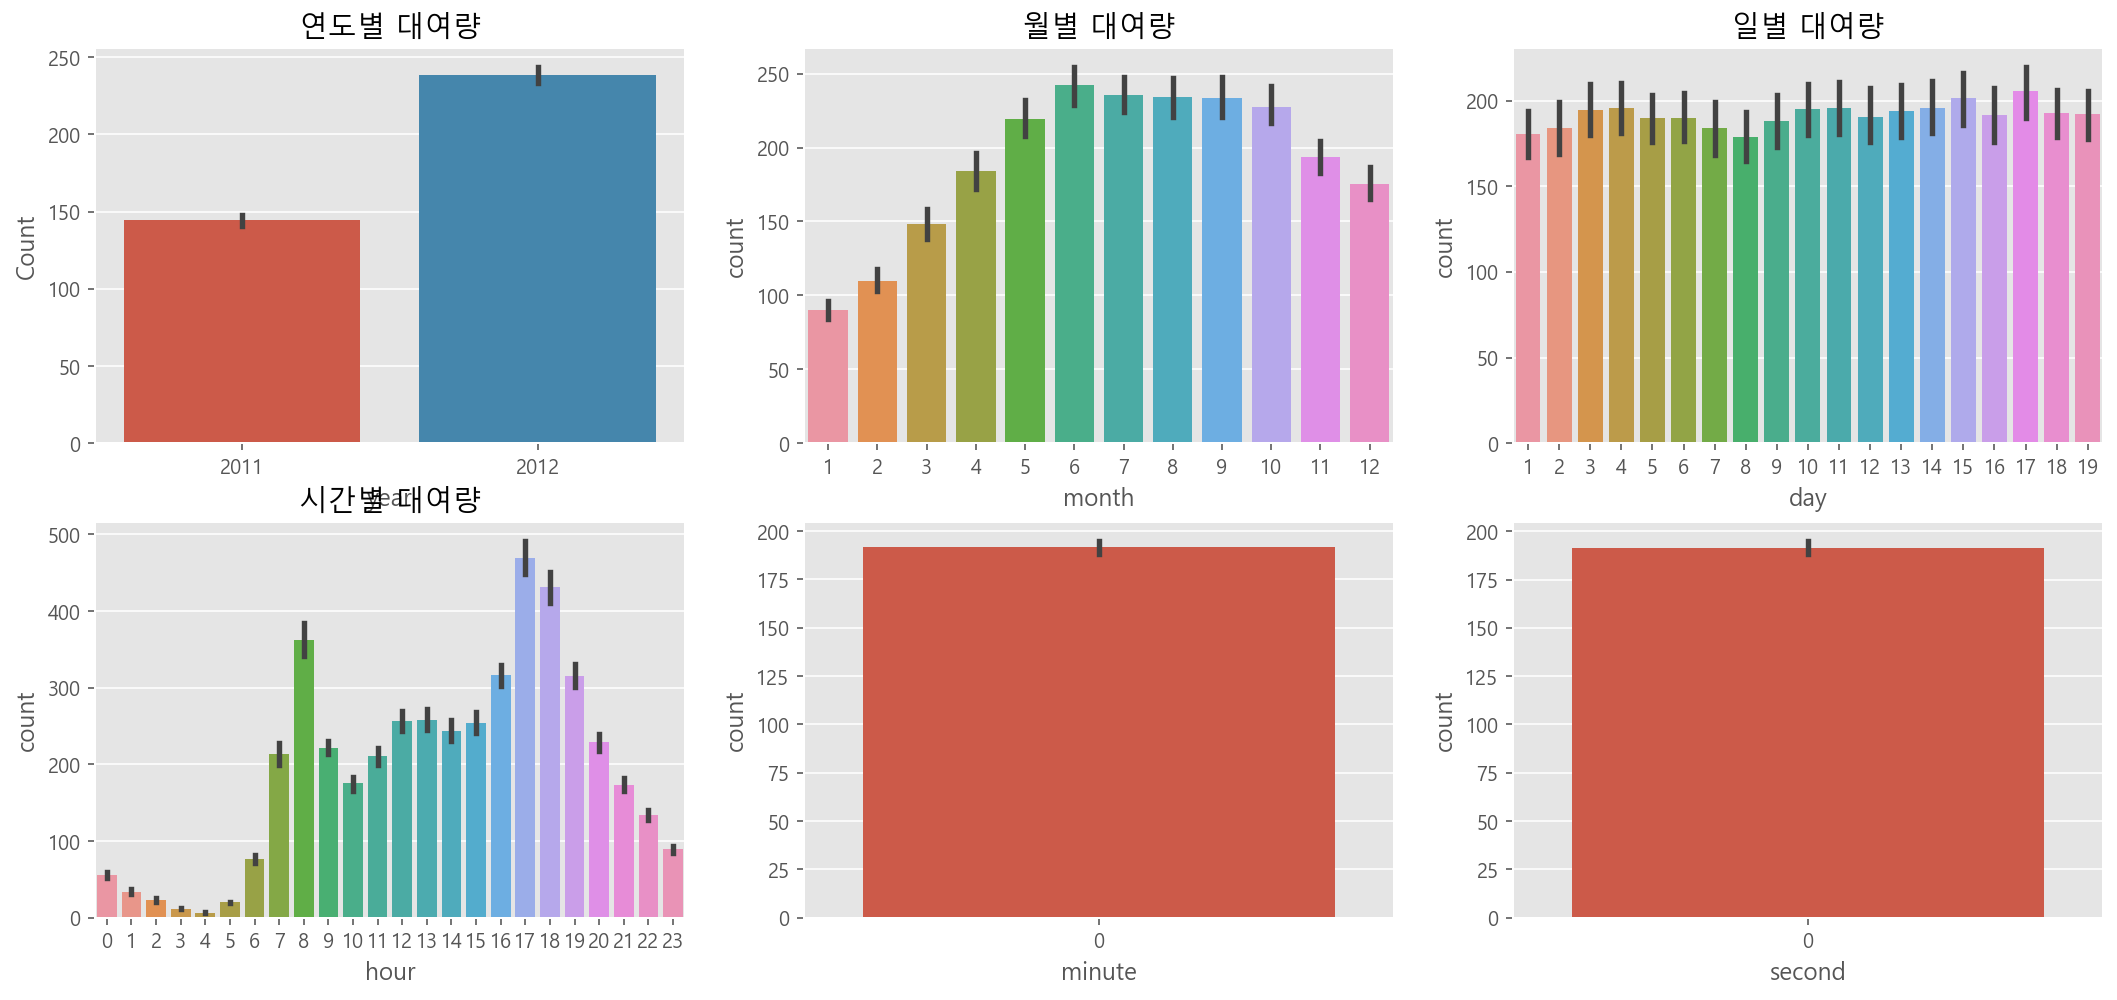

In [13]:
# 시간별 data에 따른, '대여량' 시각화
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 3)
figure.set_size_inches(18,8)

sns.barplot(data = train, x = 'year', y = 'count', ax=ax1)
sns.barplot(data = train, x = 'month', y = 'count', ax=ax2)
sns.barplot(data = train, x = 'day', y = 'count', ax=ax3)
sns.barplot(data = train, x = 'hour', y = 'count', ax=ax4)
sns.barplot(data = train, x = 'minute', y = 'count', ax=ax5)
sns.barplot(data = train, x = 'second', y = 'count', ax=ax6)

ax1.set(ylabel = 'Count', title = '연도별 대여량')
ax2.set(xlabel = 'month', title = '월별 대여량')
ax3.set(xlabel = 'day', title = '일별 대여량')
ax4.set(xlabel = 'hour', title = '시간별 대여량')

- 연도별 대여량은 2011년보다 2012년이 더 많다.
- 월별 대여량은 6월에 가장 많고, 7~10월도 대여량이 많다. 그리고 1월에 가장 적음
- 일별 대여량은 1~19일까지만 존재 (나머지 날짜는 test.csv에 있다.) => 따라서, 이 변수는 **feature로 사용하면 안됨!**
- 시간 대여량은 출퇴근 시간에 대여량이 많은 것 같지만, 주말과 나눠서 볼 필요가 있음
- 분,초가 다 0이기 때문에 의미 없음

[Text(0, 0.5, 'Working Day'), Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

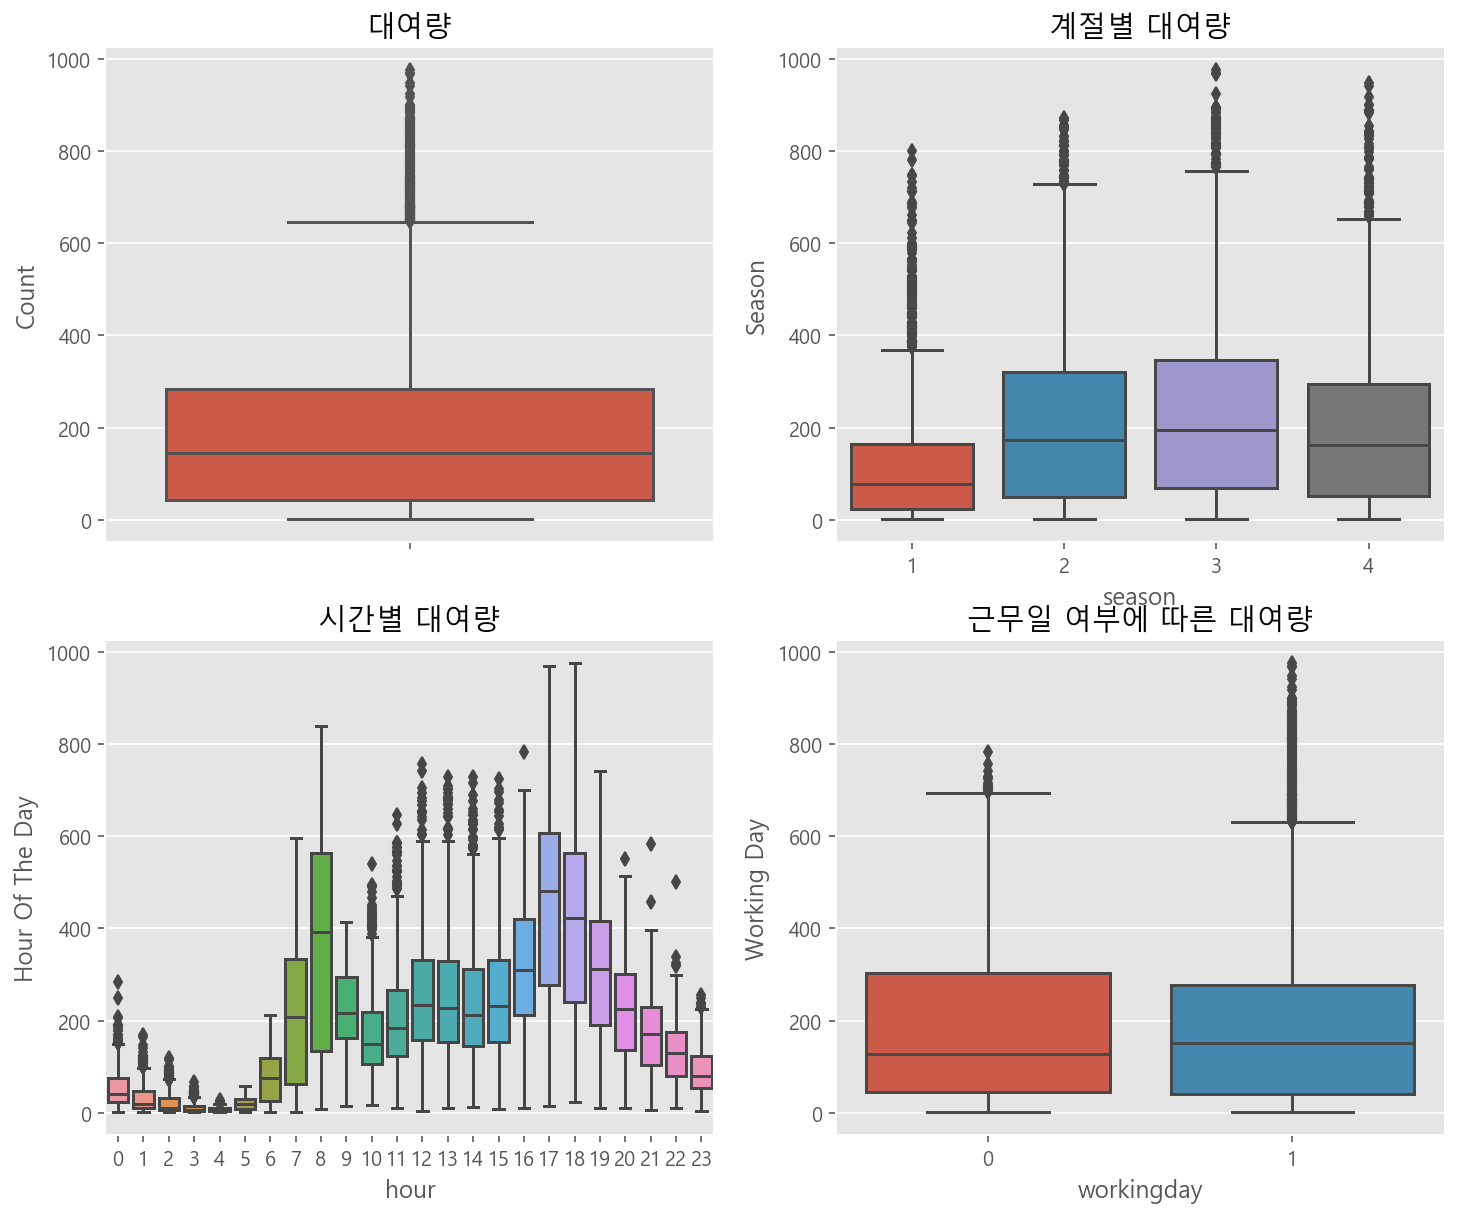

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
fig.set_size_inches(12,10)
sns.boxplot(data = train, y = 'count', orient = 'v', ax = axes[0][0])
sns.boxplot(data = train, y = 'count', x = 'season', orient = 'v', ax = axes[0][1])
sns.boxplot(data = train, y = 'count', x = 'hour', orient = 'v', ax = axes[1][0])
sns.boxplot(data = train, y = 'count', x = 'workingday', orient = 'v', ax = axes[1][1])

axes[0][0].set(ylabel = 'Count',title = '대여량')
axes[0][1].set(ylabel = 'Season',title = '계절별 대여량')
axes[1][0].set(ylabel = 'Hour Of The Day',title = '시간별 대여량')
axes[1][1].set(ylabel = 'Working Day',title = '근무일 여부에 따른 대여량')

- 대여량이 한 구간에 많이 몰려있는 양상
- 계절별로는 봄이 가장 적고, 가을이 가장 많음
- 시간별 대여량은 이 전 그래프와 비슷함
- 근무일 여부에 대여량의 큰 차이는 없지만, 공유일에 대여량이 조금 더 많음

In [15]:
# 요일 변수 추가
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [16]:
train['dayofweek'].value_counts()  # 요일에따른 대여량.. 큰 차이는 없어보임

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

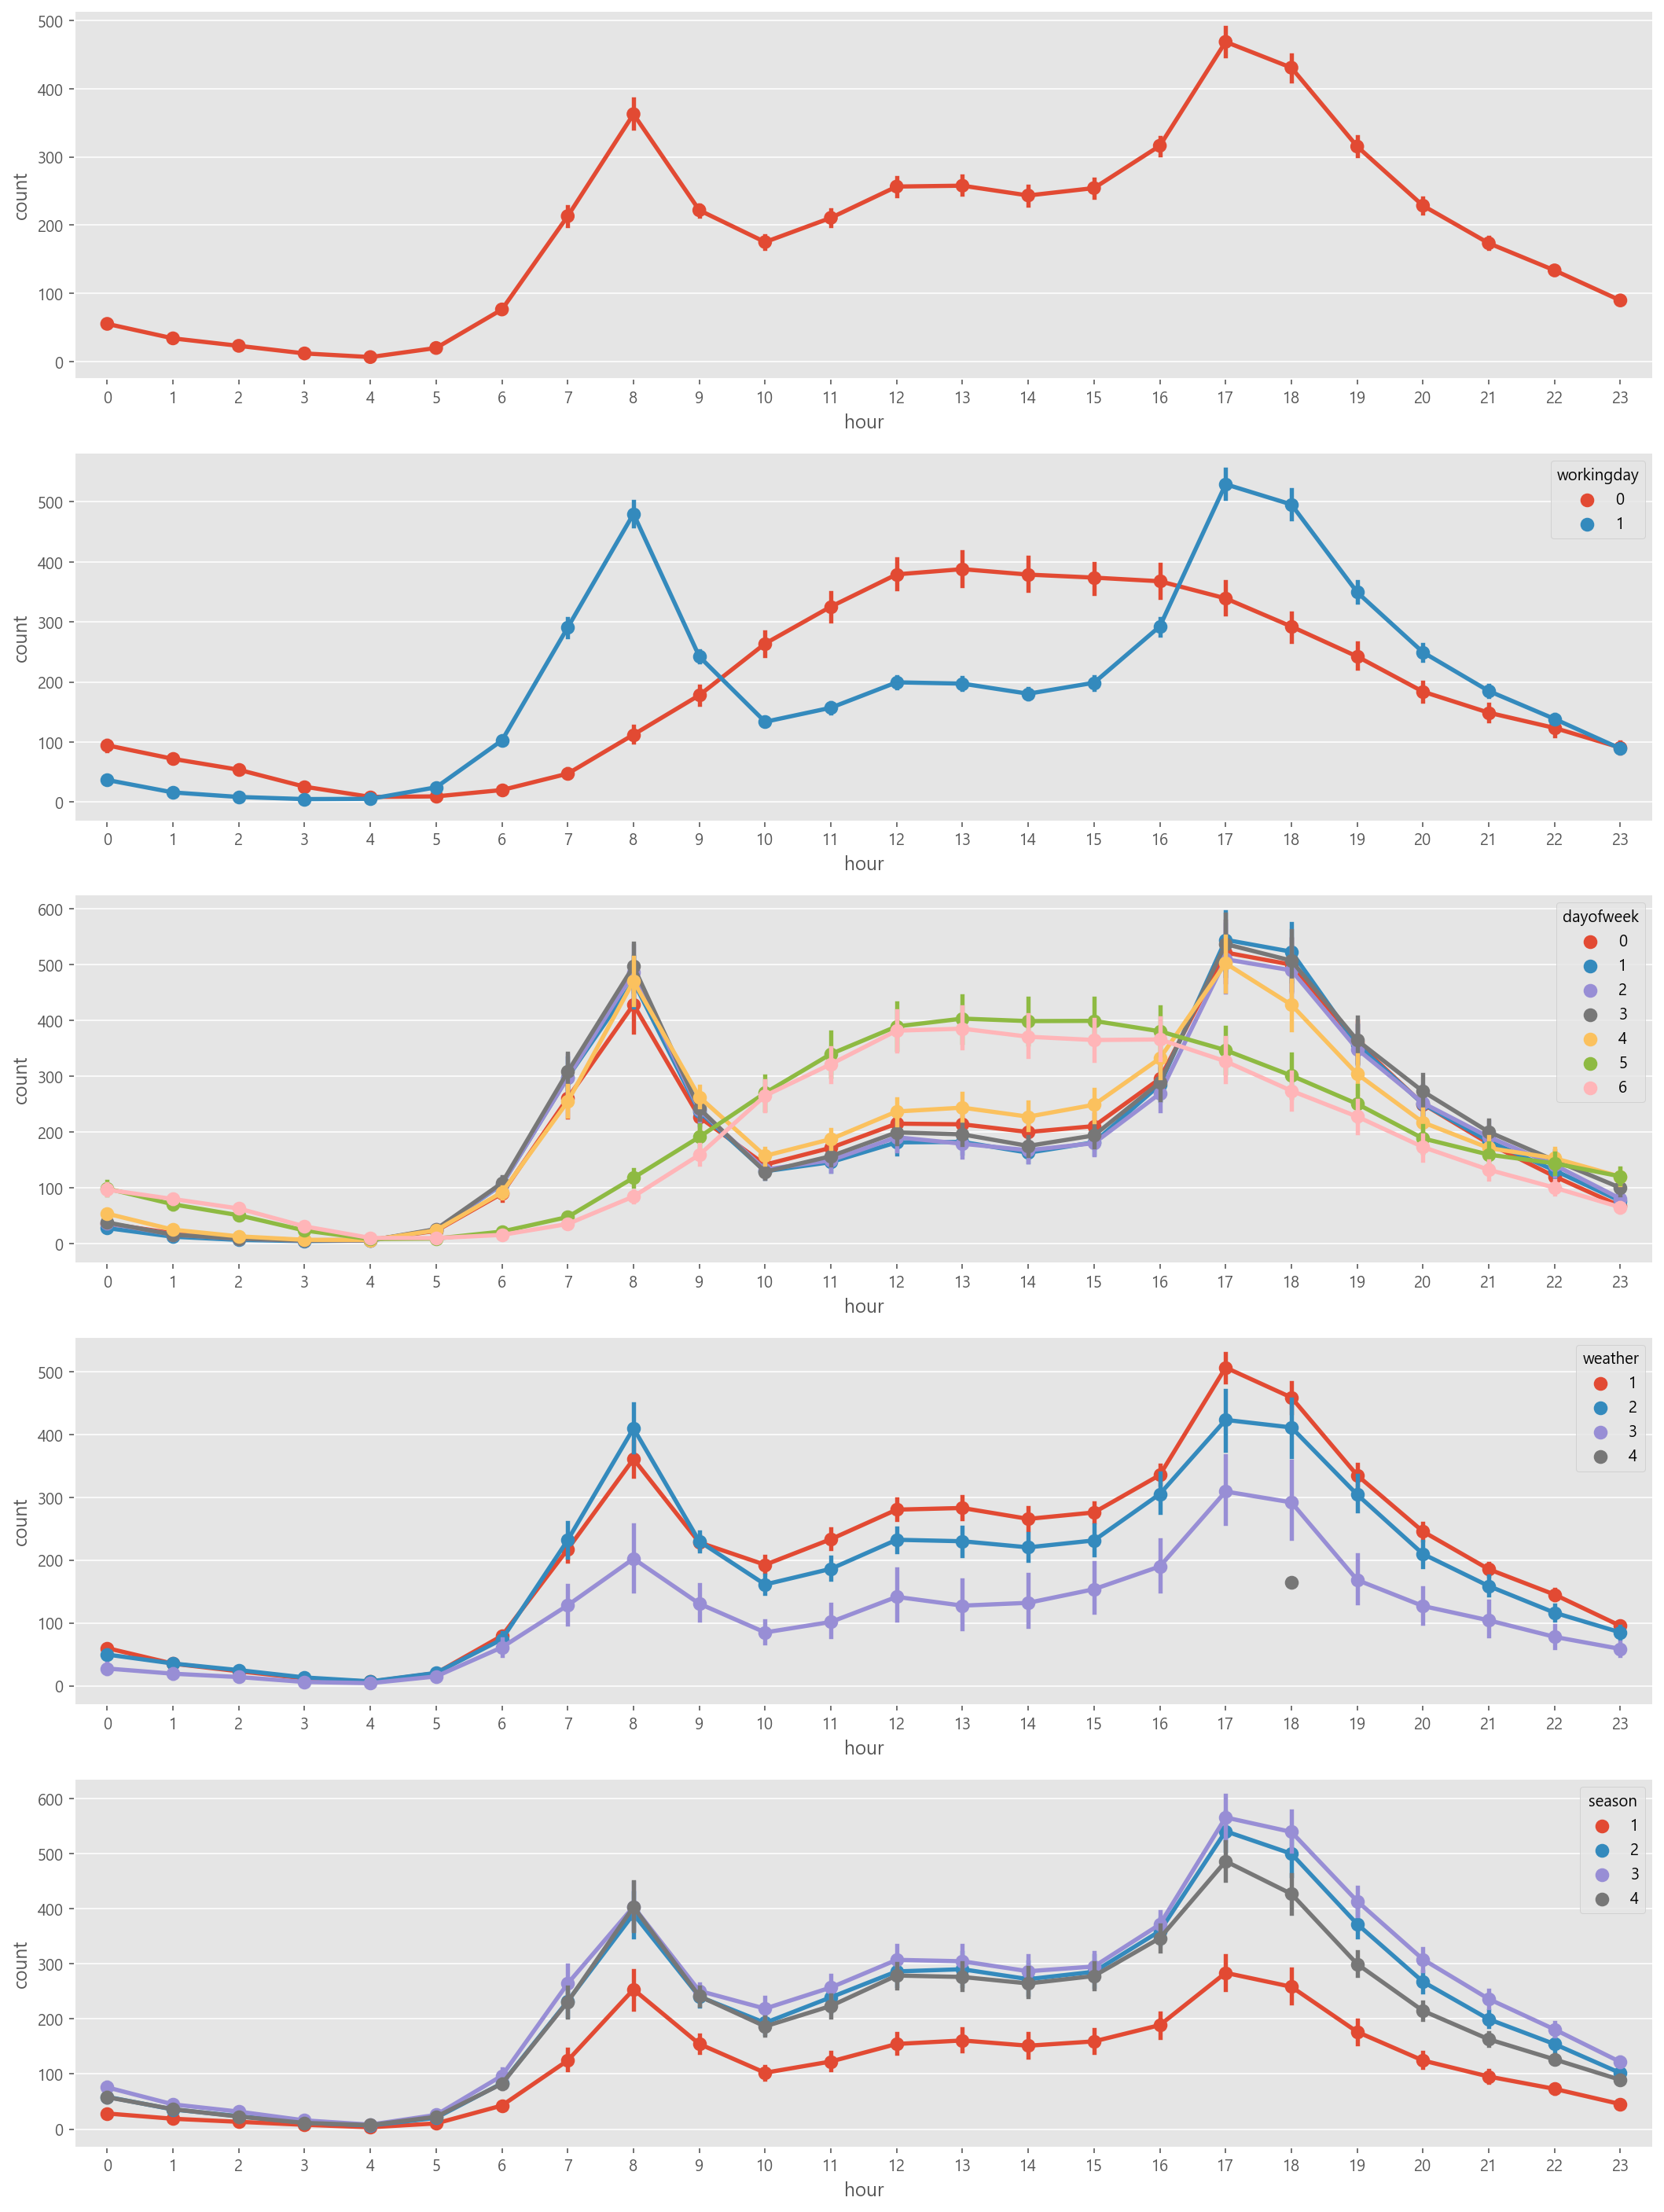

In [17]:
# 시간별 대여량 (workingday, dayofweek, weather, season에 따른)
# day of week도 그래프에 추가해서 그려보기
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train, x = 'hour', y = 'count', ax = ax1)
sns.pointplot(data=train, x = 'hour', y = 'count', hue = 'workingday', ax = ax2)
sns.pointplot(data=train, x = 'hour', y = 'count', hue = 'dayofweek', ax = ax3)
sns.pointplot(data=train, x = 'hour', y = 'count', hue = 'weather', ax = ax4)
sns.pointplot(data=train, x = 'hour', y = 'count', hue = 'season', ax = ax5)

- 공휴일, 평일의 그래프 모습이 다름. 평일은 출퇴근 시간에 가장 많고, 공휴일에는 오후시간데에 고르게 분포
- 요일에 따른 그래프도 주말, 평일에따라 나뉨
- 날씨가 좋을 때 많이 빌림
- 봄에가장 적게 빌림. 출퇴근시간에 많이 빌림

In [18]:
# 온도, 습도, 풍속 등과 대여량 간의 상관관계 파악
corrMatt = train[['temp','atemp','casual','registered','humidity','windspeed','count']]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   

               count  
temp        0.394454  
atemp       0.389784  
casual      0.690414  
registered  0.970948  
humidity   -0.317371  
windspeed   0.101369  
count       1.000000  


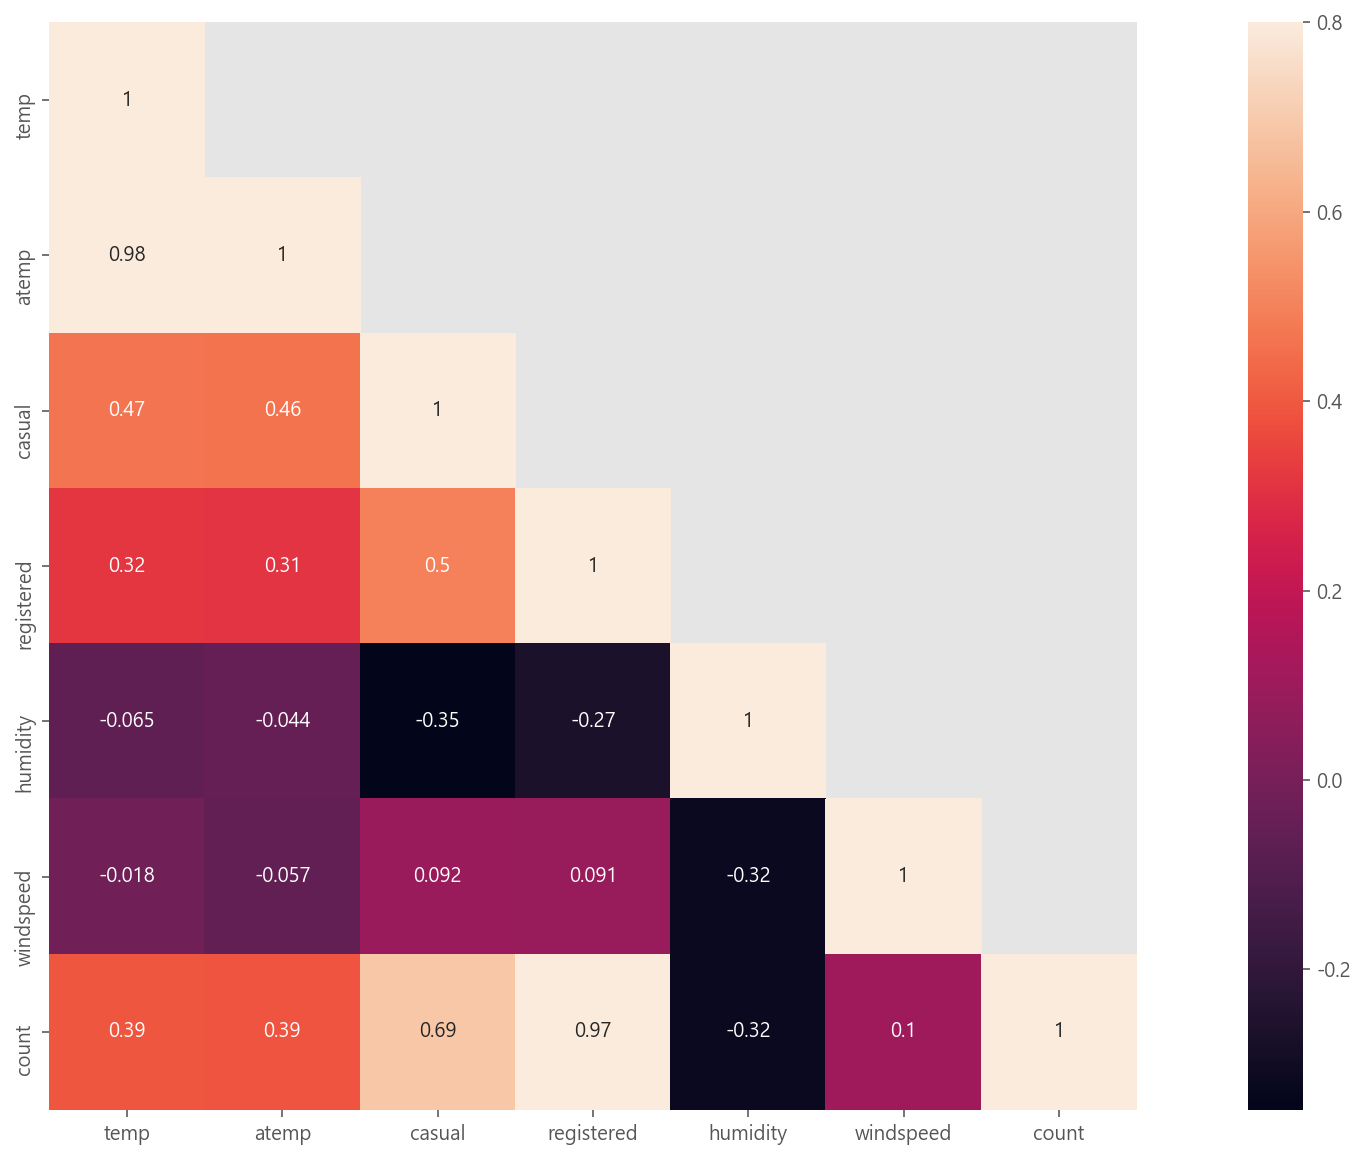

In [19]:
# 위의 상관관계를 바탕으로 heatmap 시각화
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask = mask, vmax = .8, square = True, annot = True)  # annot: 값 표시

- 습도, 풍속은 count와 거의 상관 관계가 없으며, 온도도 약한 상관관계를 나타냄
- 대여량과 가장 높은 상관관계를 보이는 것은 **registered**로 등록된 대여자이지만, test data에는 registered 값이 없음 => feature로 사용 불가
- atemp, temp 서로 상관관계가 0.98로 높아(거의 같은 data라고 볼 수 있음), **둘중 하나만 feature로 사용해야함!**

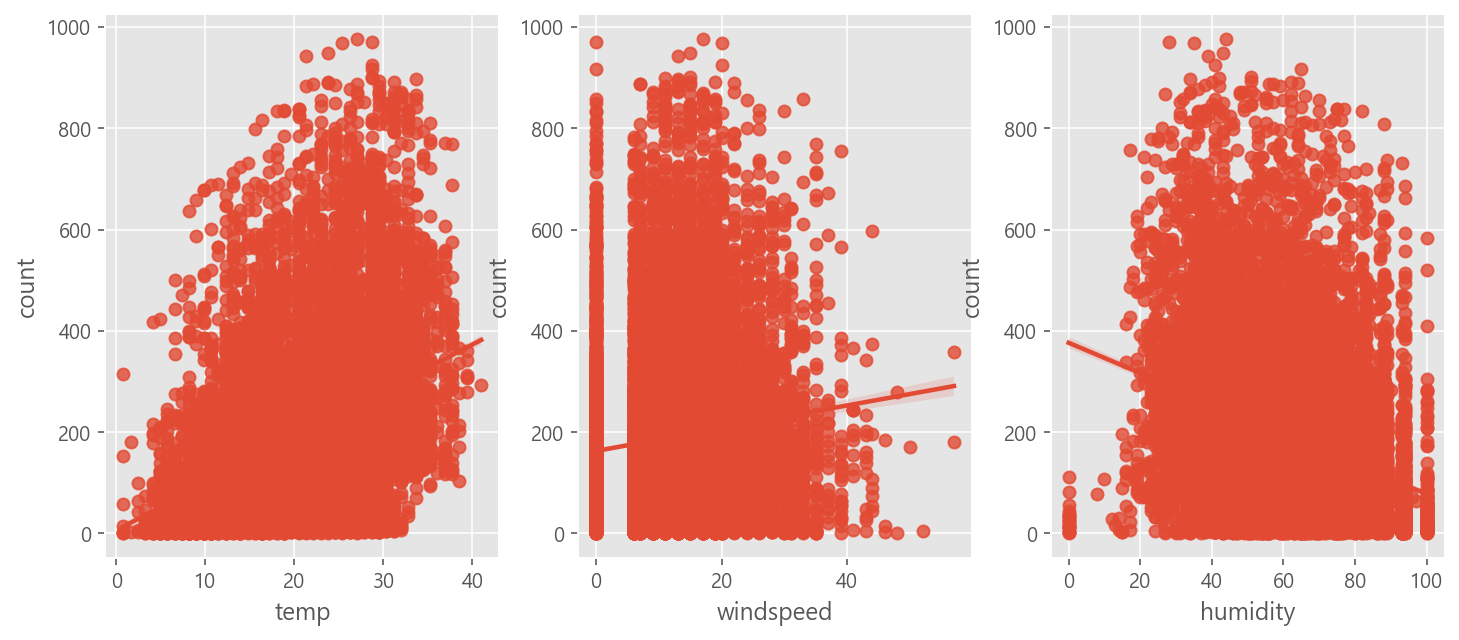

In [20]:
# 온도, 풍속, 습도  count와의 상관관계 시각화
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3)
fig.set_size_inches(12,5)
sns.regplot(x='temp', y = 'count', data=train, ax = ax1)
sns.regplot(x='windspeed', y = 'count', data=train, ax = ax2)
sns.regplot(x='humidity', y = 'count', data=train, ax = ax3)

- 풍속의 경우 0에 몰려있는 것으로 보임 (관측되지 않은 수치에 대해 0으로 기록된 것 같음)

In [21]:
# 년도와 월을 합친 변수 생성(년-월). 2011~2012 늘어난 추세 다시 확인
def concatenate_year_month(datetime):
    return '{0}-{1}'.format(datetime.year, datetime.month)

train['year_month'] = train['datetime'].apply(concatenate_year_month)

print(train.shape)
train[['datetime','year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


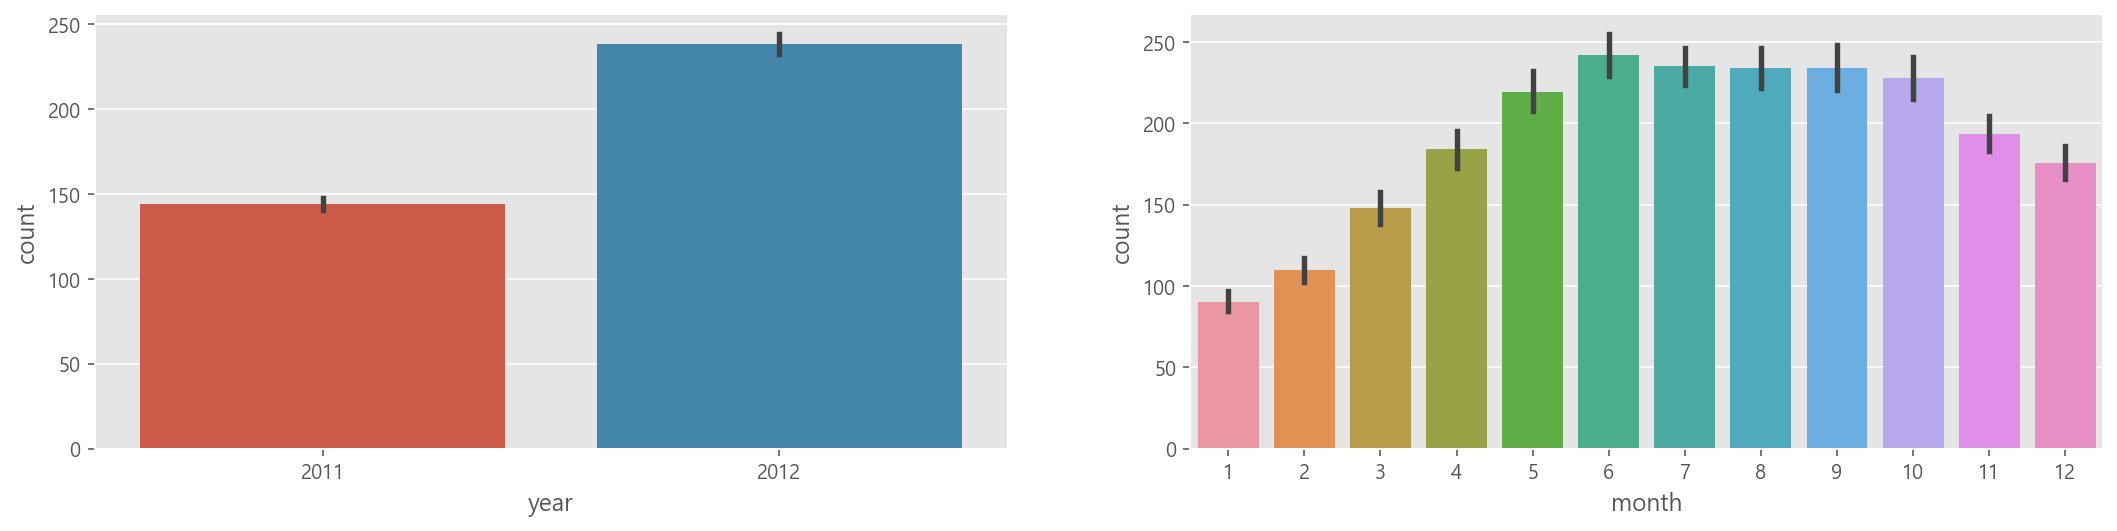

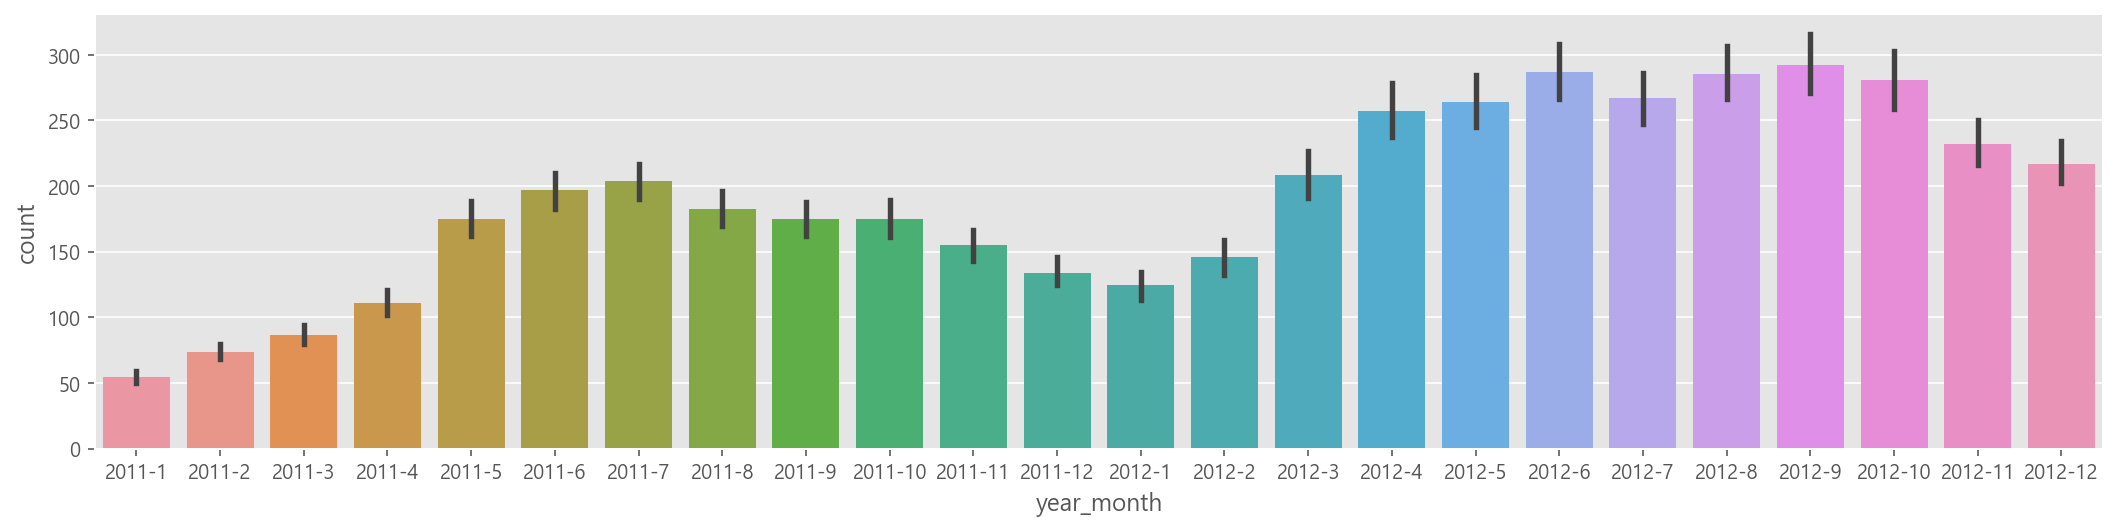

In [22]:
# 년-월 추세 확인 시각화
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols = 2)
fig.set_size_inches(18,4)

sns.barplot(data=train, x = 'year', y = 'count', ax=ax1)
sns.barplot(data=train, x = 'month', y = 'count', ax=ax2)

fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train, x='year_month', y='count', ax=ax3)

- 2011년보다 2012년에 대여량이 더 많음
- 겨울보다 날씨가 따뜻한 여름에 대여량이 더 많음
- 2011년과 2012년의 월별 데이터를 이어보면, 전체적으로 증가하는 추세(2011,2012 같은 월 비교해도, 2012 대여량이 더 많음 )

In [23]:
# outlier 제거  (0에 몰려있었던 것과 끝에 있던 outlier 제거하기)
trainWithoutOutliers = train[np.abs(train['count']  - train['count'].mean()) <= (3*train['count'].std())]

print(train.shape)   # 제거전
print(trainWithoutOutliers.shape)  #제거후

(10886, 20)
(10739, 20)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229772, 4.562423868087808, 0.958117678090961))

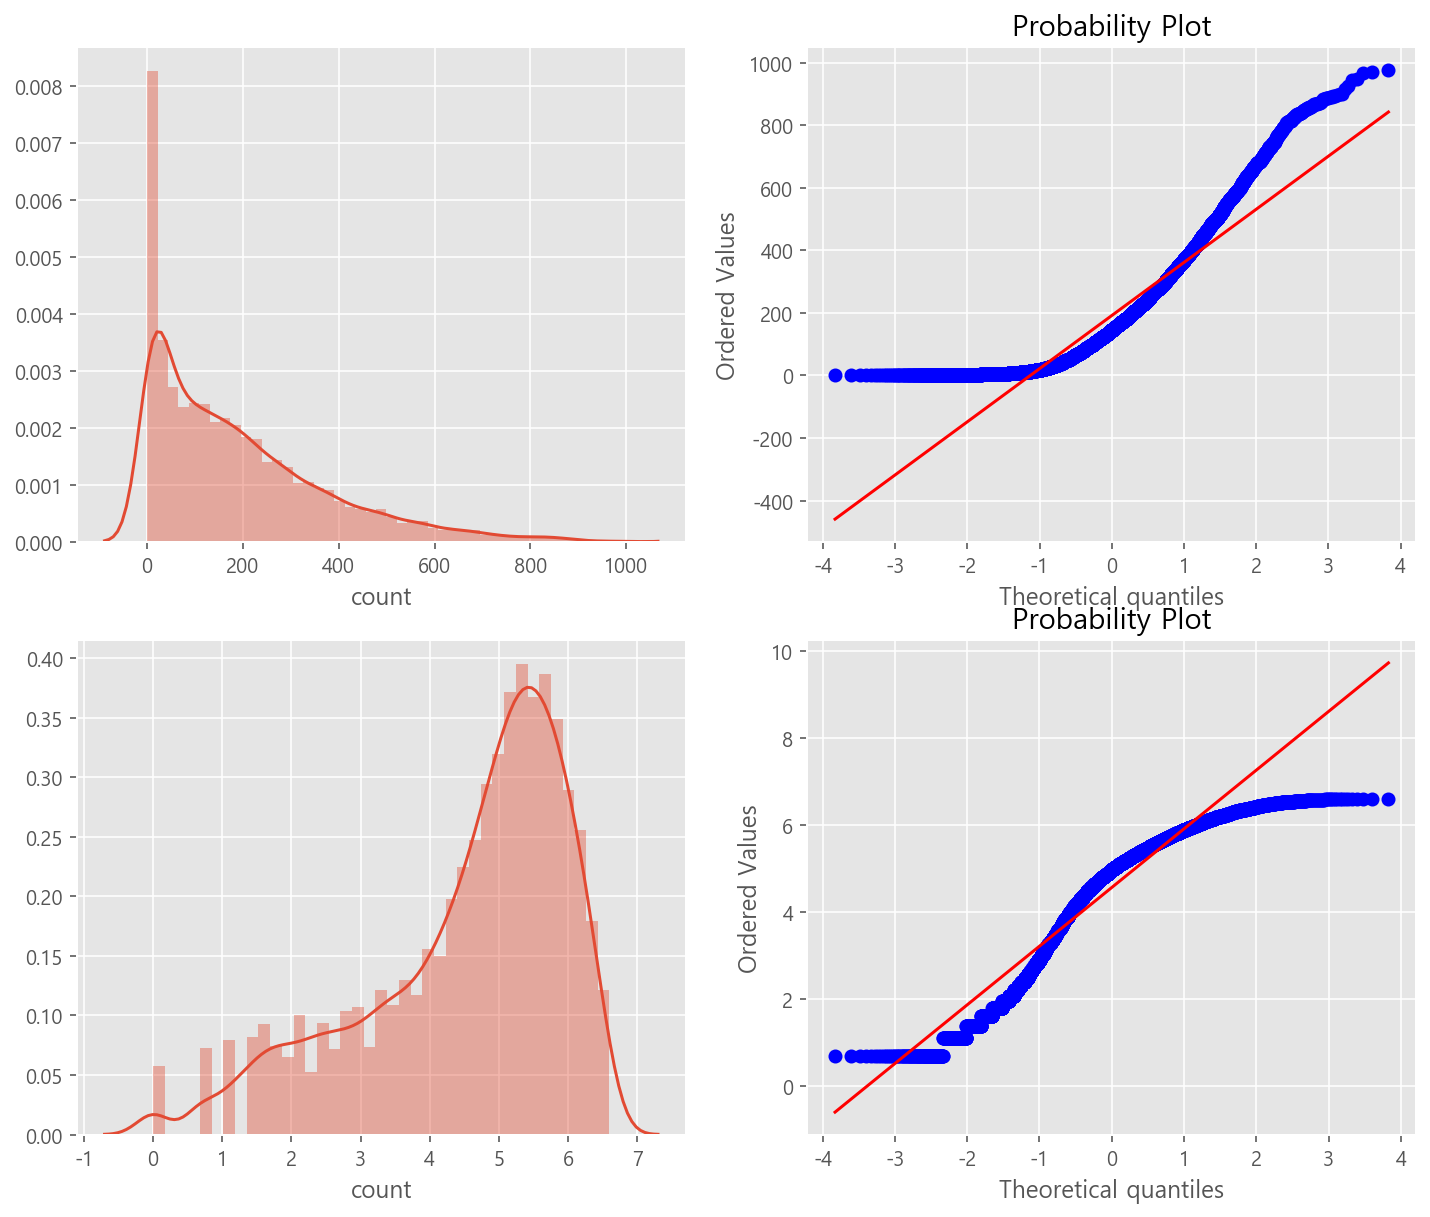

In [24]:
# outlier 삭제 전, 후 count 값의 data 분포 확인

figure, axes = plt.subplots(nrows=2, ncols=2)
figure.set_size_inches(12,10)

sns.distplot(train['count'], ax=axes[0][0])
stats.probplot(train['count'], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers['count']), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers['count']), dist='norm', fit=True, plot=axes[1][1])

- 0에 몰려있던 것을 제거한 후, 아직 정규분포까지는 아니고 **오른쪽으로 치우친 분포**를 보임
    - 대부분의 기계학습에서는 **종속변수가 normal이여야하기 때문에, 정규분포를 갖는 것이 바람직함**
    - **대안으로, outlier를 제거하고 count변수에 log를 씌워 변경하는 방법**을 수행해도, 정규분포를 따르지는 않지만, 이전 그래프보다는 좀 더 자세히 표현되고 있음.